## Logistic Regression Summary (v3 · Model Comparison Baseline)

### Feature 구성 요약

- 전체 feature 개수 (모델 입력 기준): **83**
- 수치형 feature 개수: **75**
- 범주형 feature 개수: **8**

#### 범주형 feature 목록 (명시적 지정)

- `city`
- `gender`
- `registered_via`
- `last_payment_method`
- `has_ever_paid`
- `has_ever_cancelled`
- `is_auto_renew_last`
- `is_free_user`

> 범주형 feature는 의미적으로 **코드/상태 변수**에 해당하므로  
> dtype 자동 추론을 사용하지 않고, **사전에 명시적으로 지정**함.

---

### Feature Table 사용 원칙

- 본 실험에서는 **사전에 확정된 user-level feature table**을 그대로 사용
- Logistic Regression 노트북에서는:
  - feature 추가 ❌
  - feature 제거 ❌
  - 결측치 처리 ❌
- 모델별 전처리(OHE, scaling 등)는 **학습 시점 파이프라인에서만 적용**

> 데이터 정합성은 feature table 단계에서 이미 보장된 상태이며,  
> 본 노트북은 **모델 비교 목적의 baseline 실험**에 한정됨.

---

### Logistic Regression 전처리 파이프라인

- Feature 분리:
  - 수치형: `NUMERICAL_COLS`
  - 범주형: `CATEGORICAL_COLS`
  - dtype 자동 추론 미사용

#### 수치형 처리
- 결측치 처리: **없음 (NaN = 0, 전처리 완료 상태)**
- 스케일링: `StandardScaler(with_mean=False)`
  - One-Hot Encoding 결과가 sparse matrix이므로 평균 제거 비활성화

#### 범주형 처리
- 인코딩: `OneHotEncoder(handle_unknown="ignore")`
- 출력 형태: sparse matrix

#### 통합
- `ColumnTransformer`
- `remainder="drop"`

---

### 실험 설정 요약

- 분류 모델: `LogisticRegression`
- 클래스 불균형 대응: `class_weight="balanced"`
- 결정 임계값 (threshold): **0.5 (고정)**
- 목적:
  - 하이퍼파라미터 튜닝 없이
  - 모델 간 **기본 체급 비교를 위한 baseline 모델**

---

### 데이터 분할 방식

- 분할 방식:
  - Stratified random split (`stratify = is_churn`)
  - `random_state = 42`

- 분할 구조:
  - **Train / Test split**
  - Validation set 미사용 (모델 체급 비교 단계)

- 분할 기준:
  - user-level feature table
  - 각 row는 고유 사용자(`msno`) 단위

---

### Logistic Regression Hyperparameters

- 모델: `sklearn.linear_model.LogisticRegression`
  - Objective: binary classification (logistic loss)
  - Solver: `lbfgs`
  - Regularization: L2

- 사용 파라미터:
  - `penalty`: `"l2"`
  - `C`: `1.0`
  - `max_iter`: `2000`
  - `class_weight`: `"balanced"`

---

### 평가 지표 (Test set 기준)

- **PR-AUC**
- **Recall (Churn = 1)**
- **Accuracy**
- Confusion Matrix
- Classification Report
- Feature Importance:
  - Logistic Regression coefficient

---

### 요약

- 본 Logistic Regression 모델은 **모델 간 비교를 위한 baseline**
- 성능 최적화 목적이 아닌 **상대적 성능 기준점** 역할
- 이후 RF / XGBoost / CatBoost / LightGBM 모델은  
  **동일한 데이터 분할 및 평가 기준**으로 비교 수행

# Scores (vaild/test)

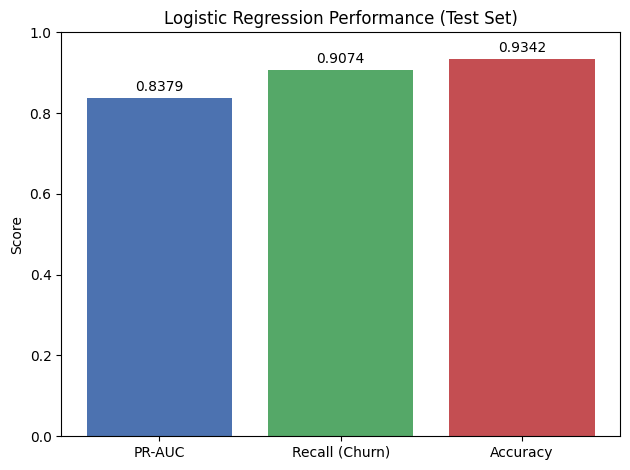

In [1]:
import matplotlib.pyplot as plt
import os

# metrics
names = ["PR-AUC", "Recall (Churn)", "Accuracy"]
values = [0.8379, 0.9074, 0.9342]

# 막대별 색상
colors = ["#4C72B0", "#55A868", "#C44E52"]

plt.figure()
bars = plt.bar(names, values, color=colors)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Logistic Regression Performance (Test Set)")

# 값 라벨
for bar, v in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        v + 0.01,
        f"{v:.4f}",
        ha="center",
        va="bottom",
    )

os.makedirs("../images/models/lr", exist_ok=True)
plt.tight_layout()
plt.savefig("../images/models/lr/fig_lr_metrics_scores.png", dpi=300)
plt.show()

# Confusion matrix (vaild/test)

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(
    cm: np.ndarray,
    title: str,
    labels=("Non-churn (0)", "Churn (1)"),
    save_path: str | None = None,
):
    """
    cm: shape (2,2) confusion matrix in form:
        [[TN, FP],
         [FN, TP]]
    """
    sns.set_theme(style="white", font_scale=1.1)

    cm = np.array(cm, dtype=int)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)  # row-normalized

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.8))

    # --- (1) Raw counts ---
    ax = axes[0]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        linewidths=0.5,
        linecolor="white",
        square=True,
        xticklabels=labels,
        yticklabels=labels,
        ax=ax,
    )
    ax.set_title(f"{title}\nCounts", weight="bold", pad=10)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    # --- (2) Row-normalized (recall view) ---
    ax = axes[1]
    sns.heatmap(
        cm_norm,
        annot=True,
        fmt=".2%",
        cmap="Blues",
        cbar=True,
        linewidths=0.5,
        linecolor="white",
        square=True,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        ax=ax,
    )
    ax.set_title(f"{title}\nRow-normalized", weight="bold", pad=10)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


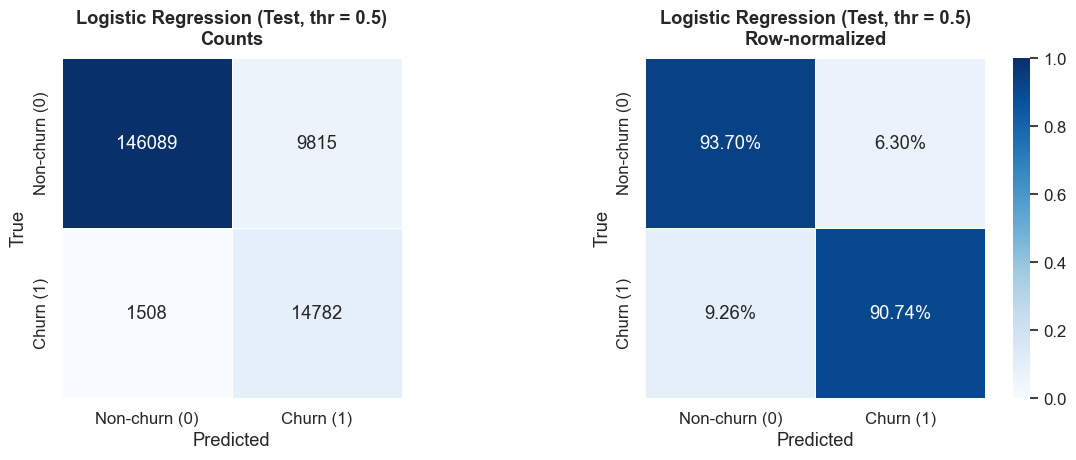

In [3]:
import numpy as np
import os

os.makedirs("../images/models/lr", exist_ok=True)

# -----------------
# LR - Test
# -----------------
cm_lr_test = np.array([
    [146089,  9815],
    [  1508, 14782],
])

plot_confusion_matrices(
    cm=cm_lr_test,
    title="Logistic Regression (Test, thr = 0.5)",
    save_path="../images/models/lr/fig_lr_confusion_test.png",
)

# Coefficient effect plot (방향 + 크기)

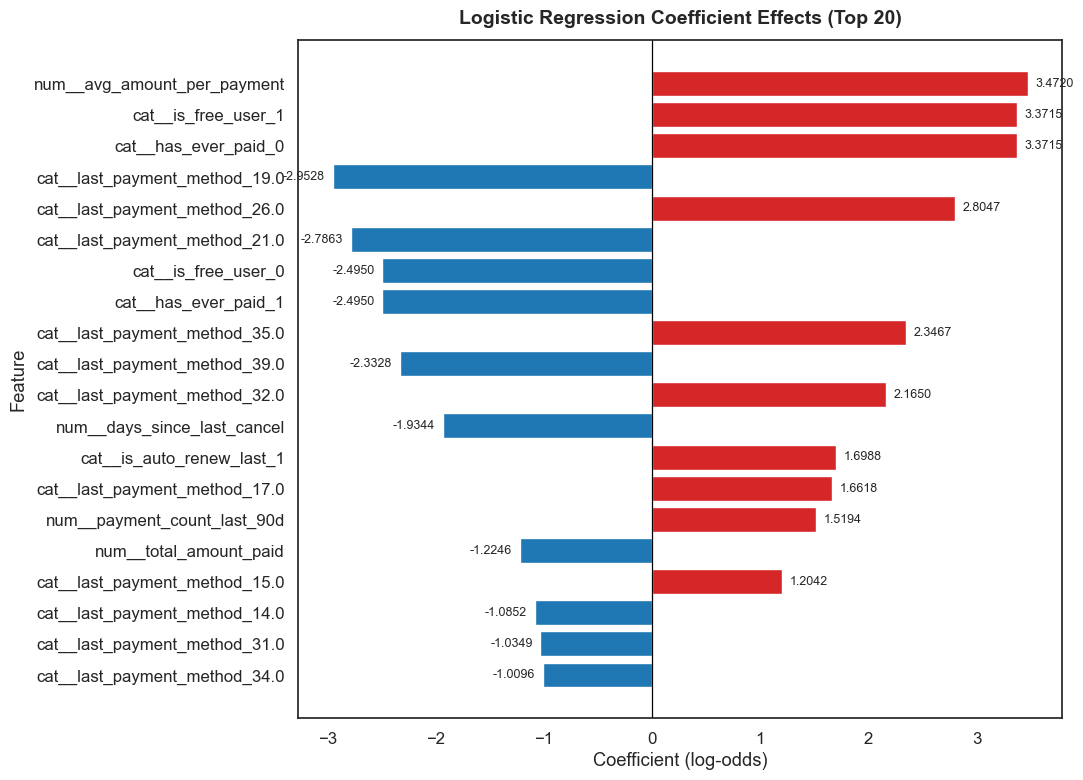

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_lr_coefficient_effect_topN(
    csv_path: str,
    top_n: int = 20,
    title: str = "Logistic Regression Coefficient Effects (Top N)",
    save_path: str | None = "../images/models/lr/fig_lr_coef_effect_top20.png",
):
    """
    CSV must contain at least columns: feature, coef
    (abs_coef is optional; if missing, it will be computed)
    """

    # -----------------
    # Load
    # -----------------
    df = pd.read_csv(csv_path)
    required = {"feature", "coef"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Found columns: {list(df.columns)}")

    if "abs_coef" not in df.columns:
        df["abs_coef"] = df["coef"].abs()

    # Top N by |coef|
    top = (
        df.sort_values("abs_coef", ascending=False)
          .head(top_n)
          .iloc[::-1]  # for barh
          .reset_index(drop=True)
    )

    # -----------------
    # Plot
    # -----------------
    plt.figure(figsize=(11, 8))
    ax = plt.gca()

    # Color by direction: churn↑ (coef>0) vs churn↓ (coef<0)
    colors = np.where(top["coef"] > 0, "#d62728", "#1f77b4")

    ax.barh(top["feature"], top["coef"], color=colors)

    # zero line
    ax.axvline(0, color="black", linewidth=0.9)

    ax.set_title(title, fontsize=14, weight="bold", pad=12)
    ax.set_xlabel("Coefficient (log-odds)")
    ax.set_ylabel("Feature")

    # value labels (coef)
    x_min, x_max = ax.get_xlim()
    pad = (x_max - x_min) * 0.01
    for i, v in enumerate(top["coef"]):
        if v >= 0:
            ax.text(v + pad, i, f"{v:.4f}", va="center", ha="left", fontsize=9)
        else:
            ax.text(v - pad, i, f"{v:.4f}", va="center", ha="right", fontsize=9)

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


# ===============================
# Usage
# ===============================
plot_lr_coefficient_effect_topN(
    csv_path="../data/model_df/lr_feature_importance.csv",
    top_n=20,
    title="Logistic Regression Coefficient Effects (Top 20)",
    save_path="../images/models/lr/fig_lr_coef_effect_top20.png",
)